In [1]:
import pprint
import numpy as np
from Crypto.Random.random import getrandbits

# Prerequisites
-  Block ciphers design

In [2]:
def get_bit(x, i, n):
    '''
    n = 5
    x = 0 1 0 1 0 
    i = 0 1 2 3 4
    '''
    return (x >> (n - 1 - i)) & 1

def inverse_sbox(S):
    """
    Input:
    S: {list} -- sbox
    Return
    {list} -- the inverse of the sbox
    """
    S_ = [-1] * len(S)
    for i, entry in enumerate(S):
        S_[entry] = i
    return S_
    

# Theory

- https://www.youtube.com/watch?v=RE6xu5THyJA&list=PLfX_2xRB__0OhOzA-rl6kvnLCCtrRoS7x&index=9 - very good explanation
- http://www.cs.bc.edu/~straubin/crypto2017/heys.pdf

For this page we denote the following
- $M$ is a message
- $C$ is a ciphertext
- $K$ is a key
- greek letters for masks

Sometimes we will denote
- $X$ - Sbox input
- $Y$ - Sbox output

Otherwise we will follow the notation from the drawings


*Idea*
- Find an approximate equation of the whole chipher - Link the bits $M_i, C_i$ and $K_i$ using a xor equation (linear equation)
- We want to look after a propriety that "degrades" over the cipher
- We want to take a subset of message bits (masked) and a subset of ciphertext bits(masked) and try to find a probabilistic linear relation between them
- Since SBoxes are the only non-linear component we want to look at those
- We want to find as much information about the key in form of equations

We define the **masks** as follows: 
> if $X = (X_0, X_1, X_2, X_3)$ a mask $\alpha = 1001$ selects the bits $X_0$ and $X_3$. 
> - We can do this with the `and` operation. 
> - Moreover since we want a linear relationship we care about the `xor` between the selected bits so we will encompass both both in the same notation.
> 
>We will denote it with $\alpha \cdot X$ (think of it like a dot product)

- For our example
$$X_0 \oplus X_3 = \bigoplus_{i=0}^n(\alpha_i X_i) = \alpha \cdot X$$




In [3]:
def bit_parity(x):
    '''
    Xor of all bits
    '''
    t = 0
    while(x != 0):
        t  = t ^ (x & 1)
        x >>= 1
    return t

def dot(x, mask):
    # We mask
    t = x & mask
    # We calculate the parity because it's a xor of all bits
    return bit_parity(t)

Now if we want to link the specific input bits to some specific output we use 2 masks ($\alpha$ for the input and $\beta$ for the output ):
$$\alpha \cdot X = \beta \cdot S(X) = \beta \cdot Y$$
- where $S$ = our sbox

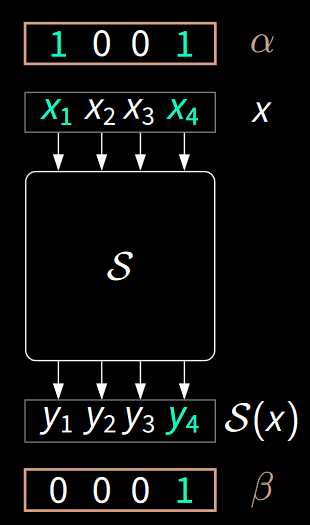

## Approximating non-linear functions by linear functions

**What is a linear function?**
>$x_n + ... + x_0 + a = y_m + ... + y_0 + b \bmod 2$  
>We consider linear functions: 0, the input bits alone or any affine transformation between them

**Reminder:** $\oplus = + \bmod 2$ 

Example: Consider the `and` gate

|x|y| xy| 
|-|-|-|
|0|0|0
|0|1|0
|1|0|0
|1|1|1

We have the following linear functions: $0, x, y, x\oplus y$ and $x\oplus y \oplus 1$

**How do we evaluate good approximations?** -- We will use different metrics
- *Matches* = How many outputs match to the input?
    - $s = |\{x \in \mathbb{F}_2^n \ : \ \alpha \cdot X = \beta \cdot S(X)\}|$
    - Ex: $x$ mathces the `and` function $3$ times. $x\oplus y$ matches once. (Write the tables)
- *Probability* $p = P_X[\alpha \cdot X = \beta \cdot S(X) = \dfrac s {2^b}$
- *Bias* $\epsilon = p - \dfrac 1 2$
    
- *Correlation* $cor = 2 \cdot \epsilon$

Interpretaion of the bias
- How different is from random? Random is right $\dfrac 1 2$ times so we subtract it
- $\epsilon = 0$ -- as good as random
- $\epsilon > 0$ -- good appr
- $\epsilon < 0$ -- bad appr but we can transform it into a good one if we `xor` by 1

In [4]:
# Consider all possible masks and check the results
def count_matches(alpha, beta, sbox, l):
    """
    Counts mathches of input output given 2 masks
    Input
        alpha: {int} -- input mask
        beta: {int} -- output mask
        sbox: {list} -- sbox
        l: {int} -- sbox intput size in bits
    Returns
        {int} -- number of matches
    """
    s = 0
    for x in range(1<<l):
        if dot(x, alpha) == dot(sbox[x], beta):
            s+=1
    return s
    
def linear_approximation_table(sbox, l):
    """
    Computes the linear approximation table
    Input
        sbox: {list} -- sbox
        l: {int} -- sbox intput size in bits
    Returns
        {list of lists} -- table
    """
    res = []
    # Iterate through possible masks
    for alpha in range(1<<l): 
        row = []
        for beta in range(1<<l):
            t = count_matches(alpha, beta, sbox, l) - 1/2 * (1<<l) # 1<<l is a normalization factor
            row.append(t)
        res.append(row)
    return res
    

In [9]:
# An sbox
S = [12, 5, 6, 11, 9, 0, 10, 13, 3, 14, 15, 8, 4, 7, 1, 2]


In [7]:
lat = linear_approximation_table(S, 4)

# Prettier print
print(np.matrix(lat))

[[ 8.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -4.  0. -4.  0.  0.  0.  0.  0. -4.  0.  4.]
 [ 0.  0.  2.  2. -2. -2.  0.  0.  2. -2.  0.  4.  0.  4. -2.  2.]
 [ 0.  0.  2.  2.  2. -2. -4.  0. -2.  2. -4.  0.  0.  0. -2. -2.]
 [ 0.  0. -2.  2. -2. -2.  0.  4. -2. -2.  0. -4.  0.  0. -2.  2.]
 [ 0.  0. -2.  2. -2.  2.  0.  0.  2.  2. -4.  0.  4.  0.  2.  2.]
 [ 0.  0.  0. -4.  0.  0. -4.  0.  0. -4.  0.  0.  4.  0.  0.  0.]
 [ 0.  0.  0.  4.  4.  0.  0.  0.  0. -4.  0.  0.  0.  0.  4.  0.]
 [ 0.  0.  2. -2.  0.  0. -2.  2. -2.  2.  0.  0. -2.  2.  4.  4.]
 [ 0.  4. -2. -2.  0.  0.  2. -2. -2. -2. -4.  0. -2.  2.  0.  0.]
 [ 0.  0.  4.  0.  2.  2.  2. -2.  0.  0.  0. -4.  2.  2. -2.  2.]
 [ 0. -4.  0.  0. -2. -2.  2. -2. -4.  0.  0.  0.  2.  2.  2. -2.]
 [ 0.  0.  0.  0. -2. -2. -2. -2.  4.  0.  0. -4. -2.  2.  2. -2.]
 [ 0.  4.  4.  0. -2. -2.  2.  2.  0.  0.  0.  0.  2. -2.  2. -2.]
 [ 0.  0.  2.  2. -4.  4. -2. -2. -2. -2.  0.  0. -2. -2.  0. 

In [8]:
# Let's look at another Sbox (Block cipher companion) 
S = [0xf, 0xe, 0xb, 0xc, 0x6, 0xd, 0x7, 0x8, 0x0, 0x3, 0x9, 0xa, 0x4, 0x2, 0x1, 0x5]
lat = linear_approximation_table(S, 4)
print(np.matrix(lat))

[[ 8.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -2.  0.  2.  0. -2.  4. -2.  2.  4.  2.  0. -2.  0.  2.  0.]
 [ 0.  2. -2.  0. -2.  0.  0.  2.  2.  4.  0.  2.  4. -2. -2.  0.]
 [ 0.  4.  2.  2. -2.  2.  0.  0.  0.  0.  2. -2. -2. -2.  0.  4.]
 [ 0.  0. -2.  2.  2. -2.  0.  0. -4.  0.  2.  2.  2.  2.  0.  4.]
 [ 0. -2.  2.  0.  2.  4.  0.  2. -2.  4.  0. -2.  0.  2. -2.  0.]
 [ 0. -2.  0.  2.  0.  2.  4.  2.  2. -4.  2.  0.  2.  0. -2.  0.]
 [ 0.  0.  0.  0.  0.  4.  0. -4.  0.  0.  0.  0.  4.  0.  4.  0.]
 [ 0.  0. -2.  2. -4.  0.  2.  2. -4.  0. -2. -2.  0.  0.  2. -2.]
 [ 0. -2. -6.  0.  0.  2. -2.  0.  2.  0.  0. -2. -2.  0.  0.  2.]
 [ 0. -2.  0. -6. -2.  0.  2.  0. -2.  0.  2.  0.  0. -2.  0.  2.]
 [ 0.  0.  0.  0.  2. -2.  2. -2.  0.  0. -4. -4.  2. -2. -2.  2.]
 [ 0.  0.  0.  0. -2. -2. -2. -2.  0.  0.  4. -4.  2.  2. -2. -2.]
 [ 0. -2.  0.  2.  2.  0. -2.  0. -2.  0.  2.  0.  0. -6.  0. -2.]
 [ 0.  2. -2.  0.  0.  2.  2. -4. -2.  0.  0.  2. -2.  0. -4. 

## Adding the key

Adding the key is simple. 
$$\alpha X \cdot \oplus \kappa \cdot K = \beta \cdot  Y$$

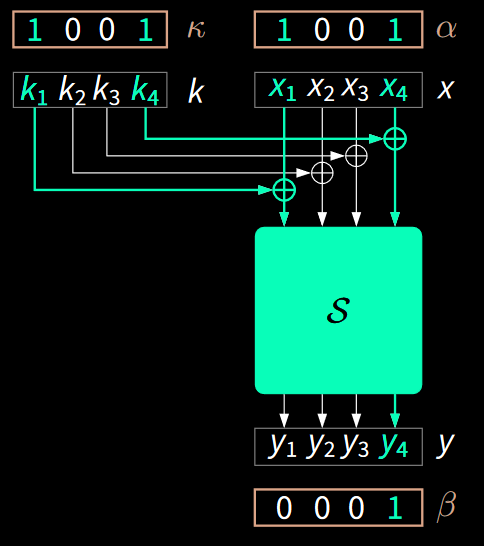

For the masks in the image we have the following equations:
$X_1 \oplus X_4 \oplus K_1 \oplus K_4 = Y_4 \\
X_1 \oplus X_4 \oplus Y_4 = K_1 \oplus K_4 $

Given enough $(X, Y)$ pairs we get some information about the key.

In [11]:
S = [12, 5, 6, 11, 9, 0, 10, 13, 3, 14, 15, 8, 4, 7, 1, 2]
lat = linear_approximation_table(S, 4)

#Investigate the lat
#print(np.matrix(lat))

In [12]:
# Pick an entry that is not 0 -> 9-1 => 4 in the LAT
alpha = 0b1001 # 9
beta = 0b0001 # 1
kappa = alpha
print("LAT entry: ", lat[alpha][beta])

X = getrandbits(4)
print("X: ", bin(X)[2:].zfill(4))
K = getrandbits(4)
print("K: ", bin(K)[2:].zfill(4))
Y = S[X ^ K]
K1K4 = dot(X, alpha) ^ dot(Y, beta)

print(K1K4 == get_bit(K, 0, 4) ^ get_bit(K, 3, 4))

LAT entry:  4.0
X:  0000
K:  0101
False


In [13]:
# Let's try more runs
t = 0
tries = 1000
for _ in range(tries):
    X = getrandbits(4)
    K = getrandbits(4)
    Y = S[X ^ K]
    K1K4 = dot(X, alpha) ^ dot(Y, beta)
    t += K1K4 == get_bit(K, 0, 4) ^ get_bit(K, 3, 4) # Increment if true
    
print(t / tries) # clearly a bias and not random

0.753


In [14]:
# Let's look at an entry equal to 0
alpha = 1
beta = 0
print("LAT entry: ", lat[alpha][beta])

t = 0
tries = 1000
for _ in range(tries):
    X = getrandbits(4)
    K = getrandbits(4)
    Y = S[X ^ K]
    K1K4 = dot(X, alpha) ^ dot(Y, beta)
    t += K1K4 == get_bit(K, 0, 4) ^ get_bit(K, 3, 4) # Increment if true
    
print(t / tries) # close to .5 thus random

LAT entry:  0.0
0.488


Let's walk through another example. This one is taken from "Block cipher companion":
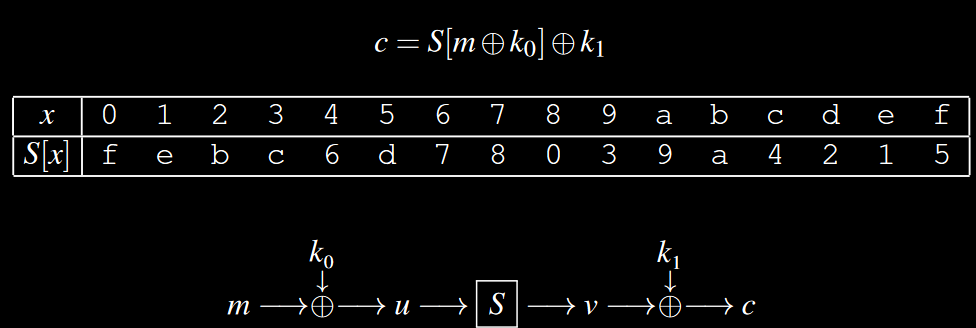

Let 
- $\alpha$ be the mask for $m$
- $\beta$ be the mask for $c$

If we play with the equations we get
- $\alpha \cdot m = \alpha \cdot k_0 \oplus \alpha \cdot u$ - always  (1)  
- $\alpha \cdot u = \beta \cdot v$ - with probability $p$  (2)  
- $\beta \cdot v = \beta \cdot k_1 \oplus \beta \cdot c$ - always  (3)  

By equating (1) with (3) through (2)
- $\alpha \cdot m \oplus \alpha \cdot k_0 = \beta \cdot k_1 \oplus \beta \cdot c \iff \\ 
\alpha \cdot m \oplus \beta \cdot c = \alpha \cdot k_0 \oplus \beta \cdot k_1$
- On the left we have $m, c$ and on the right $k_0, k_1$

In [15]:
S = [0xf, 0xe, 0xb, 0xc, 0x6, 0xd, 0x7, 0x8, 0x0, 0x3, 0x9, 0xa, 0x4, 0x2, 0x1, 0x5]
lat = linear_approximation_table(S, 4)

alpha = 0b1001
beta = 0b0010
print("LAT entry: ", lat[alpha][beta])

t = 0
tries = 1000
for _ in range(tries):
    m = getrandbits(4)
    k0 = getrandbits(4)
    k1 = getrandbits(4)

    u = m ^ k0
    v = S[u]
    c = v ^ k1
    
    # lat[alpha][beta] = -6 => we xor with 1
    t += dot(m, alpha) ^ dot(c, beta) ^ 1 == dot(k0, alpha) ^ dot(k1, beta)
    
print(t / tries) # clearly biased

LAT entry:  -6.0
0.864


## Adding more SBoxes

Consider the following scenario: 
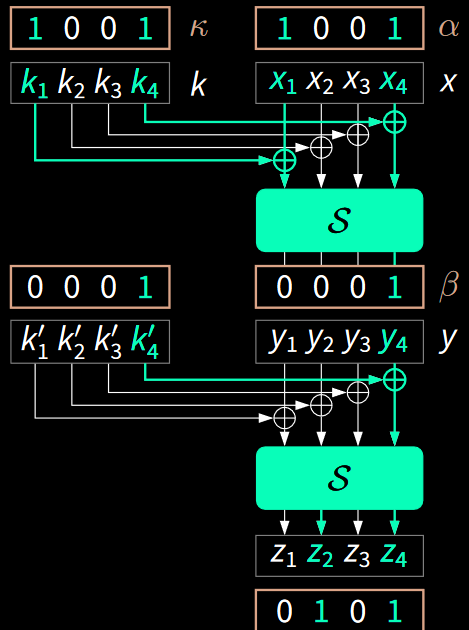

$\alpha \cdot X \oplus \kappa \cdot K = \beta \cdot Y \\
\beta \cdot y \oplus \kappa' \cdot K' = \gamma \cdot z$

For this to work we need $\kappa' = \beta$. Otherwise we use other bits that we don't know anything about. Rewriting:

$\alpha \cdot X \oplus \kappa \cdot K = \beta \cdot Y \\
\beta \cdot y \oplus \beta \cdot K' = \gamma \cdot z$

Get some good masks from the table. Equating:

$X_1 \oplus X_4 \oplus K_1 \oplus K_4 \oplus K'_4 = Z_2 \oplus Z_4 \iff \\
X_1 \oplus X_4 \oplus Z_2 \oplus Z_4 = K_1 \oplus K_4 \oplus K'_4$

In [16]:
S = [12, 5, 6, 11, 9, 0, 10, 13, 3, 14, 15, 8, 4, 7, 1, 2]
lat = linear_approximation_table(S, 4)

alpha = 0b1001
kappa = alpha
beta = 0b0001
gamma = 0b0101
print("LAT entry alpha beta: ", lat[alpha][beta])
print("LAT entry beta gamma: ", lat[beta][gamma])

t = 0
tries = 1000
for _ in range(tries):
    X = getrandbits(4)
    K = getrandbits(4)
    K_ = getrandbits(4)

    Y = S[X ^ K]
    Z = S[Y ^ K_]
    
    # lat[alpha][beta] = -6 => we xor with 1
    t += dot(X, alpha) ^ dot(Z, gamma) == dot(K, alpha) ^ dot(K_, beta)
    
print(t / tries) # clearly biased

LAT entry alpha beta:  4.0
LAT entry beta gamma:  -4.0
0.372


### Pilling up lemma

The next question arises: If we know the bias of each Sbox approximation, what is the bias of the whole picture? How can we find it?

In [17]:
# Consider the probabilities
p1 = count_matches(alpha, beta, S, 4) / (1<<4)
p2 = count_matches(beta, gamma, S, 4) / (1<<4)
print(p1, p2)

0.75 0.25


The approximation is correct if both are "wrong" or "correct". Assuming independence: 
$p = \underbrace{p_1 \cdot p_2}_{\text{correct}} + \underbrace{(1 - p_1) \cdot (1 - p_2)}_{\text{wrong}} \iff \\
p = \dfrac 1 2 + 2 \cdot \epsilon_1 \cdot \epsilon_2$

In [18]:
p = p1 * p2 + (1 - p1) * (1 - p2)
print(p) # Notice that is around what we calculated above


0.375


**The pilling up lemma**
> Let $X_i$  be **independent** boolean expressions with $p_i = P[X_i = 0] = \dfrac 1 2 + \epsilon_i$ we have the following probability:
$$P[X_1 \oplus \dots \oplus X_n = 0] = \dfrac 1 2 + 2^{n-1}\prod_{i=1}^n \epsilon_i$$
> Or in bias terms
> $$\epsilon_{1,...,n} = 2^{n-1}\prod_{i=1}^n \epsilon_i$$


- https://en.wikipedia.org/wiki/Piling-up_lemma

**Remark**
- Lemma holds, in general, only when random variables are **independent**

In [19]:
def pilling_up_lemma(eps_list):
    n = len(eps_list)
    return 2**(n-1) * np.prod(eps_list)

In [20]:
eps1 = p1 - 1/2
eps2 = p2 - 1/2
print(eps1, eps2)

p_ = 1 / 2 + 2**1 * np.prod([eps1, eps2])
p_ # It's the same as above

0.25 -0.25


0.375

## Recovering the key

### Matsui 1

This algorithm will give 1 bit of information about the key per linear approximation. Assume we have $\alpha \cdot X \oplus \beta \cdot Y \oplus \kappa \cdot K = 0$ with a positive bias (this means the equation is correct most times)

**Algorithm:**

Input:
- Many Ciphertext / Plaintext pairs

Let
- $T_0, T_1$ - 2 counters

- For each pair $(M_i, C_i)$
    - if $\alpha \cdot M_i \oplus \beta \cdot C_i = 0$ then $T_0++$
    - if $\alpha \cdot M_i \oplus \beta \cdot C_i = 1$ then $T_1++$

- We learn the following
    - If $T_0 > T_1 \Rightarrow \kappa \cdot K = 0$
    - If $T_1 > T_0 \Rightarrow \kappa \cdot K = 1$


**Cons**
- Needs approx of all rounds
- Needs several approximations
- Learns only 1 bit of information. We need more equations to get more bits


**Remark**
- We need around $\dfrac 1 { \epsilon^2}$ messages

In [21]:
def matsui1(M_list, C_list, alpha, beta):
    T0, T1 = 0, 0
    for m, c in zip(M_list, C_list):
        if dot(m, alpha) ^ dot(c, beta) == 0:
            T0+=1
        else:
            T1+=1
    if T0 > T1:
        return 0
    else:
        return 1

In [22]:
# Going back to our first example
S = [12, 5, 6, 11, 9, 0, 10, 13, 3, 14, 15, 8, 4, 7, 1, 2]
lat = linear_approximation_table(S, 4)

K = getrandbits(4)
N = 1000

M_list = []
C_list = []
# Generate messages
for _ in range(N):
    M = getrandbits(4)
    C = S[M ^ K]
    M_list.append(M)
    C_list.append(C)

In [23]:
alpha = 0b1001 # 9
beta = 0b0001 # 1
print("LAT entry: ", lat[alpha][beta])

LAT entry:  4.0


In [24]:
K1K4 = dot(K, alpha)

In [25]:
matsui1(M_list, C_list, alpha, beta) == K1K4 # True

True

Let's look at this example from "The block cipher companion":
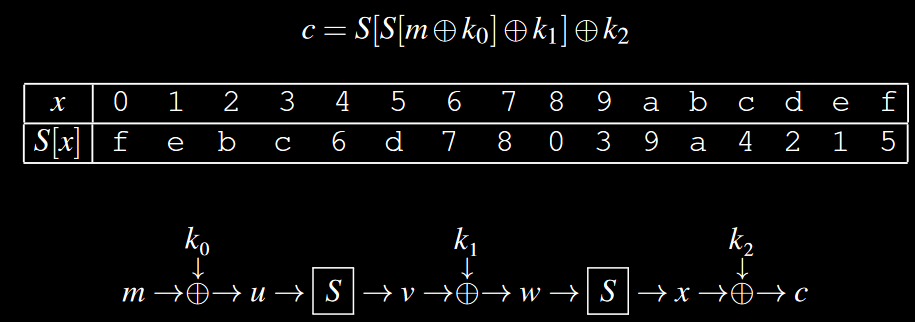

In [26]:
# Generate some ciphertext key pairs
S = [0xf, 0xe, 0xb, 0xc, 0x6, 0xd, 0x7, 0x8, 0x0, 0x3, 0x9, 0xa, 0x4, 0x2, 0x1, 0x5]
lat = linear_approximation_table(S, 4)

M_list, C_list = [], []
N = 100

k0 = getrandbits(4)
k1 = getrandbits(4)
k2 = getrandbits(4)

for _ in range(N):
    m = getrandbits(4)
    c = S[S[m ^ k0]^ k1]^ k2
    M_list.append(m)
    C_list.append(c)

In [27]:
# alpha1 -> S -> alpha2 -> S -> alpha3

# looking at the LAT we see
print(lat[0xd][0xd]) # -6
# Therefore we can use 
alpha1 = alpha2 = alpha3 = 0xd

# Attacking
print(matsui1(M_list, C_list, alpha1, alpha3) == dot(k0, alpha1) ^ dot(k1, alpha2) ^ dot(k2, alpha3))

-6.0
True


### Matsui 2

What the first algorithm didn't exploit was how strong the bias is (how different is from 0)

Assume we have an approximation to the first few rounds => we have a bias $\epsilon$ and a lot of message-ciphertext pairs. 
- We can brute force more key bits and decrypt to the bias-known round => $C'$
- If $\alpha \cdot M =  \beta \cdot C'$ increase $T_0$ else increase $T_1$
- The right key will behave similar to the bias. 
    - If we chose a large positive bias then $T_0 \gg T_1$ or reverse
    
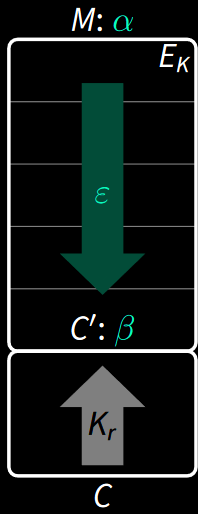

Consider the following cipher from The block cipher companion:
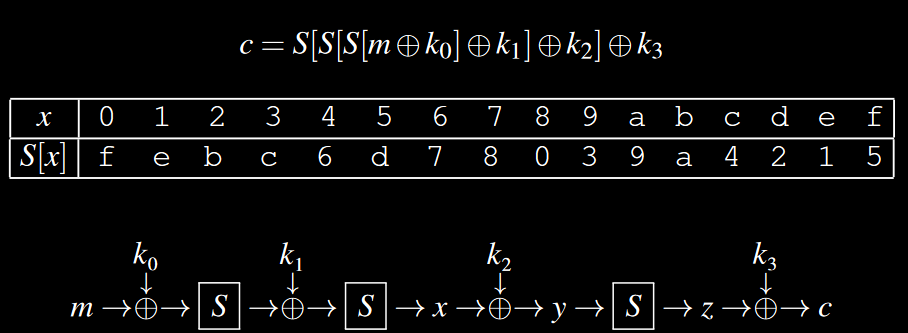

In [28]:
# Generate some ciphertext key pairs
S = [0xf, 0xe, 0xb, 0xc, 0x6, 0xd, 0x7, 0x8, 0x0, 0x3, 0x9, 0xa, 0x4, 0x2, 0x1, 0x5]
lat = linear_approximation_table(S, 4)

M_list, C_list = [], []
N = 1000

k0 = getrandbits(4)
k1 = getrandbits(4)
k2 = getrandbits(4)
k3 = getrandbits(4)

for _ in range(N):
    m = getrandbits(4)
    c = S[S[S[m ^ k0]^ k1]^ k2] ^ k3
    M_list.append(m)
    C_list.append(c)

In [29]:
print(np.matrix(lat))

[[ 8.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -2.  0.  2.  0. -2.  4. -2.  2.  4.  2.  0. -2.  0.  2.  0.]
 [ 0.  2. -2.  0. -2.  0.  0.  2.  2.  4.  0.  2.  4. -2. -2.  0.]
 [ 0.  4.  2.  2. -2.  2.  0.  0.  0.  0.  2. -2. -2. -2.  0.  4.]
 [ 0.  0. -2.  2.  2. -2.  0.  0. -4.  0.  2.  2.  2.  2.  0.  4.]
 [ 0. -2.  2.  0.  2.  4.  0.  2. -2.  4.  0. -2.  0.  2. -2.  0.]
 [ 0. -2.  0.  2.  0.  2.  4.  2.  2. -4.  2.  0.  2.  0. -2.  0.]
 [ 0.  0.  0.  0.  0.  4.  0. -4.  0.  0.  0.  0.  4.  0.  4.  0.]
 [ 0.  0. -2.  2. -4.  0.  2.  2. -4.  0. -2. -2.  0.  0.  2. -2.]
 [ 0. -2. -6.  0.  0.  2. -2.  0.  2.  0.  0. -2. -2.  0.  0.  2.]
 [ 0. -2.  0. -6. -2.  0.  2.  0. -2.  0.  2.  0.  0. -2.  0.  2.]
 [ 0.  0.  0.  0.  2. -2.  2. -2.  0.  0. -4. -4.  2. -2. -2.  2.]
 [ 0.  0.  0.  0. -2. -2. -2. -2.  0.  0.  4. -4.  2.  2. -2. -2.]
 [ 0. -2.  0.  2.  2.  0. -2.  0. -2.  0.  2.  0.  0. -6.  0. -2.]
 [ 0.  2. -2.  0.  0.  2.  2. -4. -2.  0.  0.  2. -2.  0. -4. 

In [30]:
# alpha1 - alpha 2 -> 1st Sbox
# alpha2 - alpha3 -> 2nd Sbox
# alpha3 - alpha4 - > 3rd Sbox

alpha1 = 0b1001 # 9
alpha2 = 0b0010 # 2
alpha3 = 0b1001 # 9
alpha4 = 0b0010 # 2

# or

alpha1 = alpha2 = alpha3 = alpha4 = 0xd

In [31]:
eps1 = count_matches(alpha1, alpha2, S, 4) / (1<<4) - 1/2
eps2 = count_matches(alpha2, alpha3, S, 4) / (1<<4) - 1/2
eps3 = count_matches(alpha3, alpha4, S, 4) / (1<<4) - 1/2
print(eps1, eps2, eps3)


-0.375 -0.375 -0.375


In [32]:
eps = pilling_up_lemma([eps1, eps2])
print(eps)
p = eps + 1/2
print(p) # Therefore we expect `p` correct cases

0.28125
0.78125


In [33]:
1/eps**2

12.641975308641975

In [34]:
def matsui2(M_list, C_list, alpha, beta, S_, key_bits = 4):
    """
    Does R-1 key attack
    Input:
        M_list: {list} -- messages
        C_list: {list} -- ciphertext
        alpha: {int} -- input mask
        beta: {int} -- penultimate round mask
        S_: {list} -- Sbox INVERSE
        key_bits: {int}, default=4 -- number of key bits to search through
        
    Return:
    {list} -- list of differences. Take the max difference for the key
    """
    t_diffs = []
    for k in range(1<<key_bits): # Iterate through possible keys
        t0, t1 = 0, 0
        for m, c in zip(M_list, C_list):
            # Reverse one round
            c_ = c ^ k
            c_ = S_[c_]
            # Check if the statement is correct
            if dot(m, alpha) == dot(c_, beta) :
                t0+=1
            else:
                t1+=1
        print(t0, t1)
        t_diffs.append(t0 - t1)
    return t_diffs

In [35]:
k3

8

In [36]:
S_ = inverse_sbox(S)
t_diffs = matsui2(M_list, C_list, alpha1, alpha3, S_)

123 877
748 252
249 751
755 245
773 227
112 888
769 231
239 761
888 112
227 773
761 239
231 769
252 748
877 123
245 755
751 249


In [37]:
np.argmax(t_diffs)

8

In [38]:
np.argsort(np.abs(t_diffs))[::-1]

array([ 8,  5, 13,  0,  9,  4, 11,  6, 10,  7, 14,  3, 15,  2, 12,  1],
      dtype=int64)

## Bigger block cipher

Let's work on the SPN cipher we defined in the "Design of block ciphers" notebook


In [ ]:
# Substitute and permute

def substitute(x, sbox, l):
    """
    Takes a 2**n bit number x and substitutes n-bit parts according to the n-bit sbox
    Arguments
        x: {int} --  input number of size 2**n bits
        sbox: {Sbox} -- Sbox with input entries of size n bits
        l: {int} -- Sbox input size in bits
    Returns 
        {int} -- output sboxed
    """
    word_size = 1 << l
    mask = (1<<l) - 1
    y = 0
    for i in range(0, word_size, l): # Steps of n-bits
        y  = y << l # Shift 'l' positions to make space for l-bit sbox number
        idx = (x >> (word_size - i - l)) & mask # Get n-bit index in the sbox
        y = y | sbox[idx] # "append" the bit from x
    return y
        
        
def permute(x, pbox, n):
    """
    Takes a n-bit int x and permutes the bits from it according to the pbox
    Arguments
        x: {int}  -- n-bit int
        pbox: {list} -- list of integers of length n
    Return: 
        {int}
    """
    y = 0
    for p in pbox:
        y = y << 1 # shift to make space for LSB 
        y = y ^ get_bit(x, p, n) # "append" the p'th bit from x
    return y


class SPN:
    def __init__(self, sbox, pbox, block_size = 16, sbox_input_size = 4):
        self.sbox = sbox
        self.sbox_ = inverse_sbox(sbox)
        self.pbox = pbox
        self.block_size = block_size
        self.l = sbox_input_size
        
    def key_schedule(self, k):
        return [k >> i * 4 & 0xffff for i in range(4, -1, -1)]

    def encrypt(self, m: int, k: int) -> int:
        ks = self.key_schedule(k)
        
        w = m
        for i in range(len(ks) - 2):
            u = w ^ ks[i]
            v = substitute(u, self.sbox, self.l)
            w = permute(v, self.pbox, self.block_size)
            
        u = w ^ ks[-2] 
        v = substitute(u, S, self.l)
        y = v ^ ks[-1]
        
        return y
    
    
    def decrypt(self, c: int, k: int) -> int:
        
        ks = self.key_schedule(k)
        
        v = ks[-1] ^ c
        u = substitute(v, self.sbox_, self.l)
        w = ks[-2] ^ u
        
        for ki in ks[::-1][2:]:
            v = permute(w, self.pbox, self.block_size)
            u = substitute(v, self.sbox_, self.l)
            w = u ^ ki
        return w

We shall follow this path

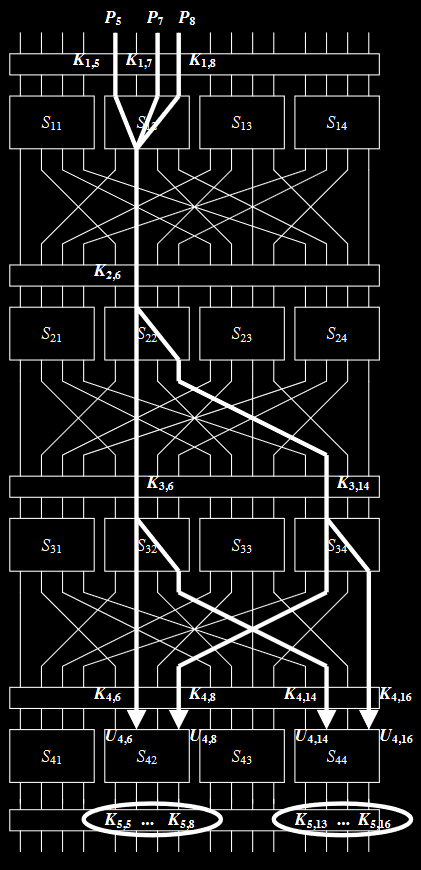

In [53]:
#Sbox and Pbox
S = [14, 4, 13, 1, 2, 15, 11, 8, 3, 10, 6, 12, 5, 9, 0, 7]
S_ = inverse_sbox(S)
P = [0, 4, 8, 12, 1, 5, 9, 13, 2, 6, 10, 14, 3, 7, 11, 15]

In [41]:
lat = linear_approximation_table(S, 4)

In [42]:
print(np.matrix(lat))

[[ 8.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -2. -2.  0.  0. -2.  6.  2.  2.  0.  0.  2.  2.  0.  0.]
 [ 0.  0. -2. -2.  0.  0. -2. -2.  0.  0.  2.  2.  0.  0. -6.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  2. -6. -2. -2.  2.  2. -2. -2.]
 [ 0.  2.  0. -2. -2. -4. -2.  0.  0. -2.  0.  2.  2. -4.  2.  0.]
 [ 0. -2. -2.  0. -2.  0.  4.  2. -2.  0. -4.  2.  0. -2. -2.  0.]
 [ 0.  2. -2.  4.  2.  0.  0.  2.  0. -2.  2.  4. -2.  0.  0. -2.]
 [ 0. -2.  0.  2.  2. -4.  2.  0. -2.  0.  2.  0.  4.  2.  0.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -2.  2.  2. -2.  2. -2. -2. -6.]
 [ 0.  0. -2. -2.  0.  0. -2. -2. -4.  0. -2.  2.  0.  4.  2. -2.]
 [ 0.  4. -2.  2. -4.  0.  2. -2.  2.  2.  0.  0.  2.  2.  0.  0.]
 [ 0.  4.  0. -4.  4.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -2.  4. -2. -2.  0.  2.  0.  2.  0.  2.  4.  0.  2.  0. -2.]
 [ 0.  2.  2.  0. -2.  4.  0.  2. -4. -2.  2.  0.  2.  0.  0.  2.]
 [ 0.  2.  2.  0. -2. -4.  0.  2. -2.  0.  0. -2. -4.  2. -2. 

In [34]:
alpha0 = 0b1011
alpha1 = 0b0100
alpha2 = 0b0101

In [38]:
eps1 = count_matches(alpha0, alpha1, S, 4) / (1<<4) - 1/2
eps2 = count_matches(alpha1, alpha2, S, 4) / (1<<4) - 1/2
eps3 = count_matches(alpha1, alpha2, S, 4) / (1<<4) - 1/2
eps4 = count_matches(alpha1, alpha2, S, 4) / (1<<4) - 1/2
print(eps1, eps2, eps3, eps4)

0.25 -0.25 -0.25 -0.25


In [115]:
eps = pilling_up_lemma([eps1, eps2, eps3, eps4])
print(eps)
print(1/eps**2)

-0.03125
1024.0


In [132]:
def matsui2_big(M_list, C_list, alpha, beta, S_, key_bits = 8):
    """
    Does R-1 key attack
    Input:
        M_list: {list} -- messages
        C_list: {list} -- ciphertext
        alpha: {int} -- input mask
        beta: {int} -- penultimate round mask
        S_: {list} -- Sbox INVERSE
        key_bits: {int}, default=4 -- number of key bits to search through
        
    Return:
    {list} -- list of differences. Take the max difference for the key
    """
    t_diffs = []
    for k in range(1<<key_bits): # Iterate through possible keys
        k1, k2 = (k>>4) & 0xf, k & 0xf 
        t0, t1 = 0, 0
        for m, c in zip(M_list, C_list):
            # Reverse one round
            c_ = c ^ (k1 << 8) ^ k2
            c_ = substitute(c_, S_, 4)
            # Check if the statement is correct
            if dot(m, alpha) == dot(c_, beta):
                t0+=1
            else:
                t1+=1
        #print(t0, t1)
        t_diffs.append(t0 - t1)
    return t_diffs

In [133]:
# Generate (m, c) pairs

spn = SPN(S, P)
K = getrandbits(48)
Ks = spn.key_schedule(K)

N = 10000
M_list = []
C_list = []
for _ in range(N):
    m = getrandbits(16)
    c = spn.encrypt(m, K)
    M_list.append(m)
    C_list.append(c)
    


In [134]:
t_diffs = matsui2_big(M_list, C_list, 0x0b00, 0x0505, S_)

In [135]:
(Ks[-1] & 0xf00) >> 8, Ks[-1] & 0xf

(10, 1)

In [137]:
kk = np.argsort(np.abs(t_diffs))[::-1]

# Take first key
for key in kk[:1]:
    print(key, (key & 0xf0) >> 4, key & 0xf)

161 10 1


## Defense against linear crypntalysis

# Resources
- https://www.youtube.com/watch?v=RE6xu5THyJA&list=PLfX_2xRB__0OhOzA-rl6kvnLCCtrRoS7x&index=9 - very good explanation
- https://www.youtube.com/watch?v=1BU_fG8j51w
- http://www.cs.bc.edu/~straubin/crypto2017/heys.pdf
- https://marc-stevens.nl/research/mastermath/2015/cryptanalysis_notes_ch8_v1.pdf
- The block cipher companion
- Cryptography Theory and practice